In [1]:
import os
import pickle
import yaml

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from attributedataset.datasetutils import get_dataset

import cv2
from PIL import Image
import torchvision.transforms.functional as TF

%load_ext autoreload
%autoreload 2

def label_list_to_str(labels, label_to_str):
    ret = []
    for i, label in enumerate(labels):
        if label == 1:
           ret.append(label_to_str[i])
    return ret 

In [6]:
# define specific path here
#log_dir = './logs'
#project_name = 'BoostCAM_FullActivate_18_pascal'
#postfix = 'msk0.0_lr-5_wd-6'

# or load config file here
config_path = 'configs/pascal/pascal_config_boost_msk0.1.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

log_dir = config['LOGGING']['log_dir']
project_name = config['LOGGING']['project'] + '_' + config['DATASET']['name']
postfix = config['LOGGING']['postfix']

visualize_dir = os.path.join(log_dir, project_name, postfix)
print(visualize_dir)

config['DATASET']['pkl_file'] = config['DATASET']['pkl_list'][0]

train_dataset, test_dataset, metainfo = get_dataset(config)

num_classes = metainfo['num_classes']
label_str = metainfo['label_str']

./logs/BoostCAM18_FullActivate_pascal/b32_msk.1_lr-5


In [7]:
print(metainfo)

{'label_str': ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'], 'num_classes': 20}


# Visualize metrics

In [8]:
epoch = 4
gt_file = f'gt_{epoch}.npy'
pred_file = f'preds_{epoch}.npy'
metric_file = f'metrics_{epoch}.pkl'

# read gt, pred, metric
gt_PATH = os.path.join(visualize_dir, gt_file)
pred_PATH = os.path.join(visualize_dir, pred_file)
metric_PATH = os.path.join(visualize_dir, metric_file)

gt = np.load(gt_PATH)
pred = np.load(pred_PATH)

with open(metric_PATH, 'rb') as f:
    metrics = pickle.load(f)

prefix = 'unmasked_'
mA = metrics[prefix+'mA']
acc = metrics[prefix+'acc']
prec = metrics[prefix+'prec']
recall = metrics[prefix+'recall']
f1 = metrics[prefix+'f1']

FileNotFoundError: [Errno 2] No such file or directory: './logs/BoostCAM18_FullActivate_pascal/b32_msk.1_lr-5/gt_4.npy'

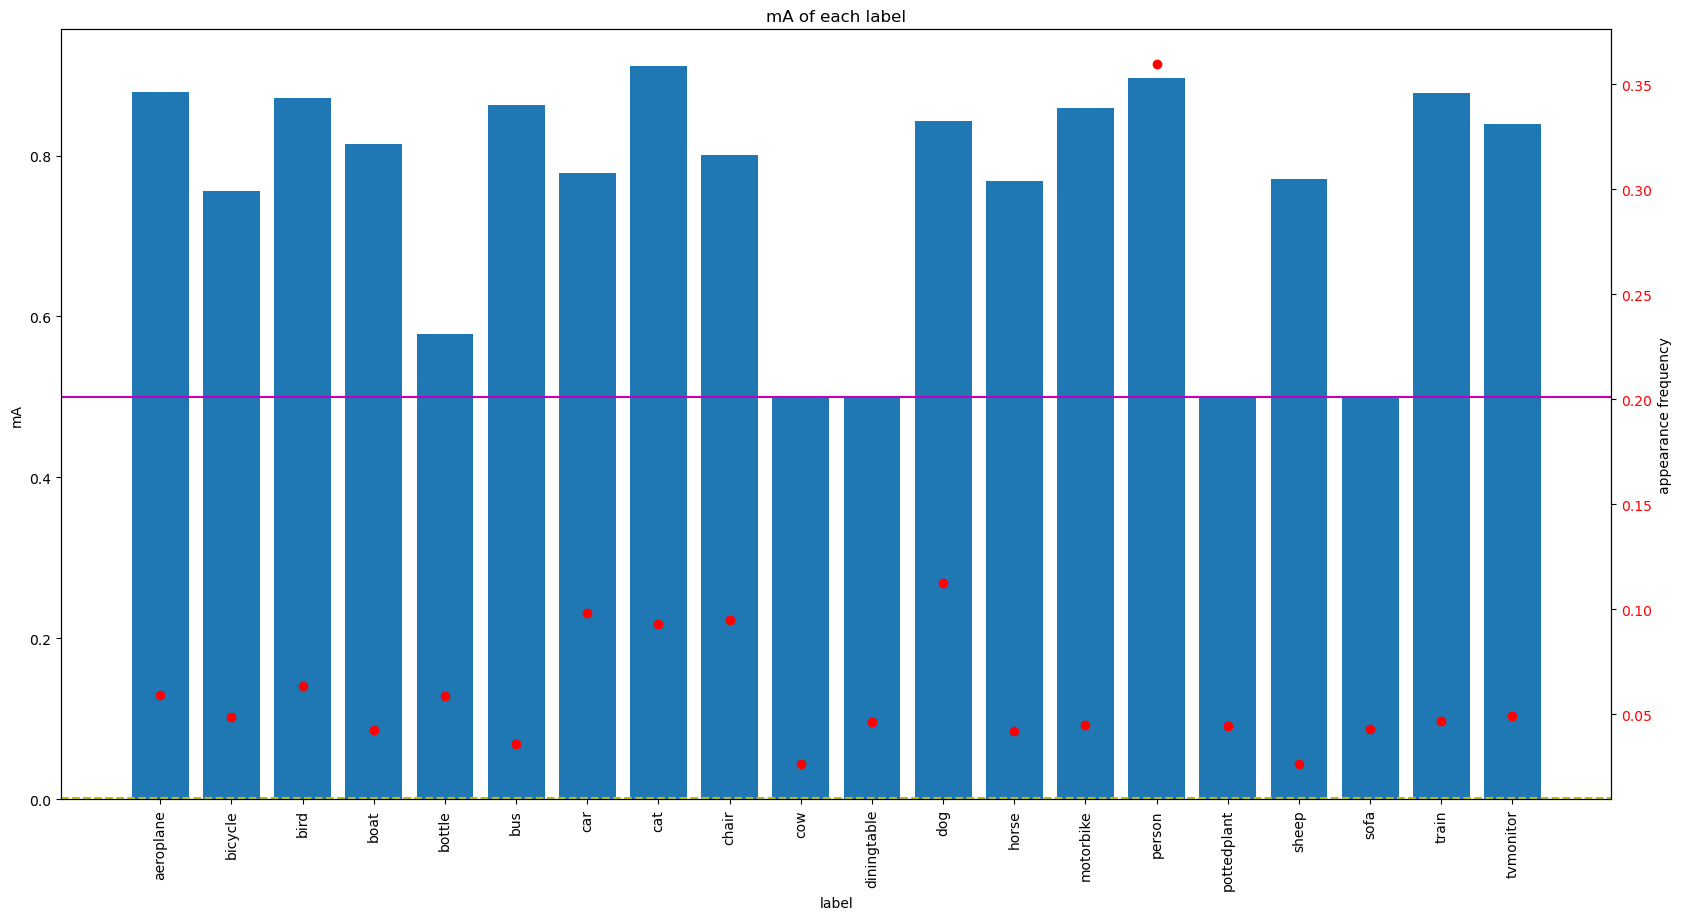

In [9]:
# plot mA of each label from 0.5
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
ax1.bar(np.arange(num_classes), mA)
# red horizontal line
ax1.axhline(y=0.5, color='m', linestyle='-')
ax1.set_xticks(np.arange(num_classes), train_dataset.label_str, rotation=90)
ax1.set_xlabel('label')
ax1.set_ylabel('mA')

ax2 = ax1.twinx()
ax2.plot(np.arange(num_classes), gt.mean(axis=0), 'ro', label='gt')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('appearance frequency')
# draw a line
ax2.axhline(y=0.01, color='y', linestyle='--')
plt.title('mA of each label')
plt.show()

# Visualize CAMS

In [17]:
epoch = 4

def get_torch(root_dir, file):
    PATH = os.path.join(root_dir, file)
    return torch.load(PATH)

traincam = get_torch(visualize_dir, f'traincam_{epoch}.pth').cpu()
trainimg = get_torch(visualize_dir, f'trainimg_{epoch}.pth').cpu()
testcam = get_torch(visualize_dir, f'testcam_{epoch}.pth').cpu()
testimg = get_torch(visualize_dir, f'testimg_{epoch}.pth').cpu()

traintarget = get_torch(visualize_dir, f'traintarget_{epoch}.pth')
trainpred = get_torch(visualize_dir, f'trainpred_{epoch}.pth')
trainmask = get_torch(visualize_dir, f'trainmask_{epoch}.pth')
testtarget = get_torch(visualize_dir, f'testtarget_{epoch}.pth')
testpred = get_torch(visualize_dir, f'testpred_{epoch}.pth')
testmask = get_torch(visualize_dir, f'testmask_{epoch}.pth')

np_traincam = traincam.numpy()
np_trainimg = trainimg.numpy()
np_testcam = testcam.numpy()
np_testimg = testimg.numpy()

In [18]:
# unnormalize the image
def unnormalize(img):
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
    mn = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    st = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    img = img * st + mn
    img = np.transpose(img, (1, 2, 0))
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


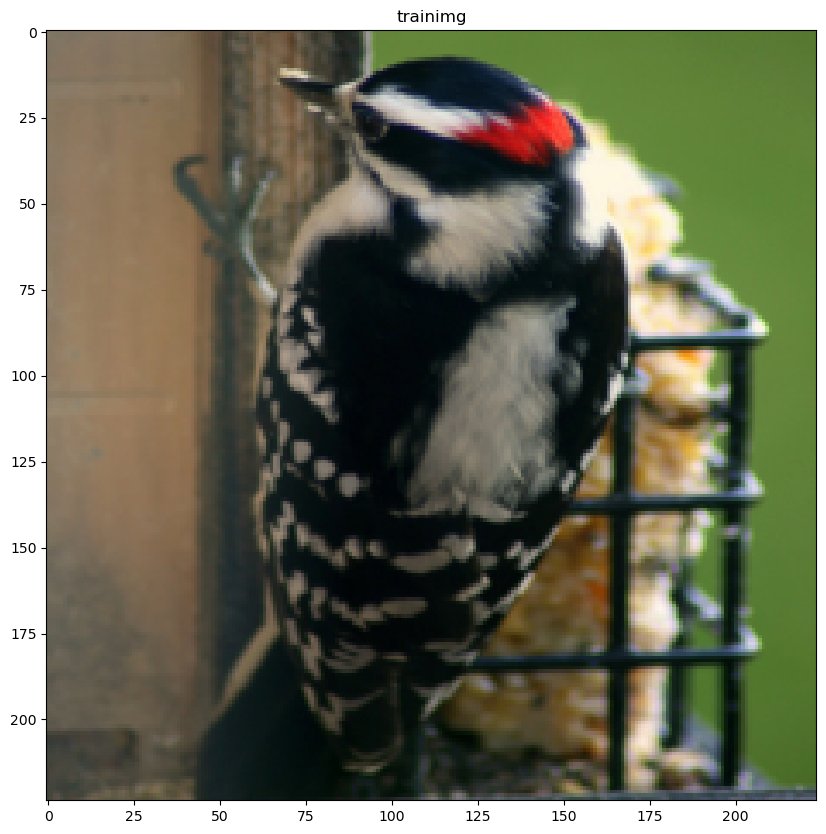

In [19]:
idx = 0

# plot trainimg
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
img = unnormalize(np_trainimg[idx])
ax1.imshow(img)
ax1.set_title('trainimg')
plt.show()

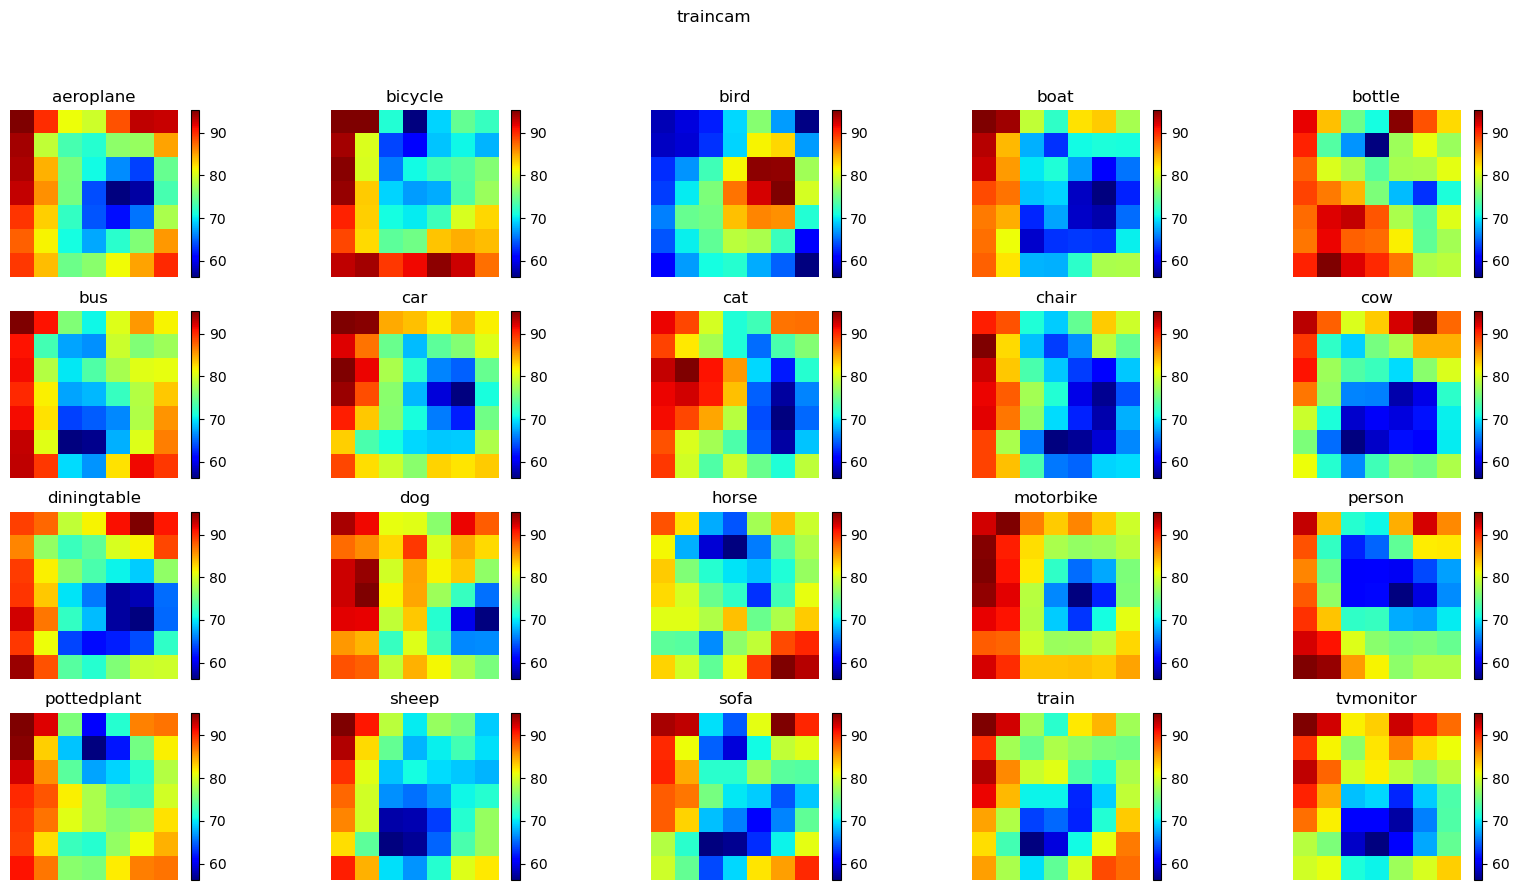

In [13]:
# plot traincam
fig = plt.figure(figsize=(20, 10))

for class_idx in range(num_classes):
    ax = fig.add_subplot(4,5,class_idx+1)
    ax.imshow(np_traincam[idx, class_idx, :, :], cmap='jet')
    # ax1 colorbar
    cbar = plt.colorbar(ax1.imshow(np_traincam[idx, 0, :, :], cmap='jet'), ax=ax)

    ax.set_title(label_str[class_idx])

    # remove axis
    ax.axis('off')

plt.suptitle('traincam')
plt.show()


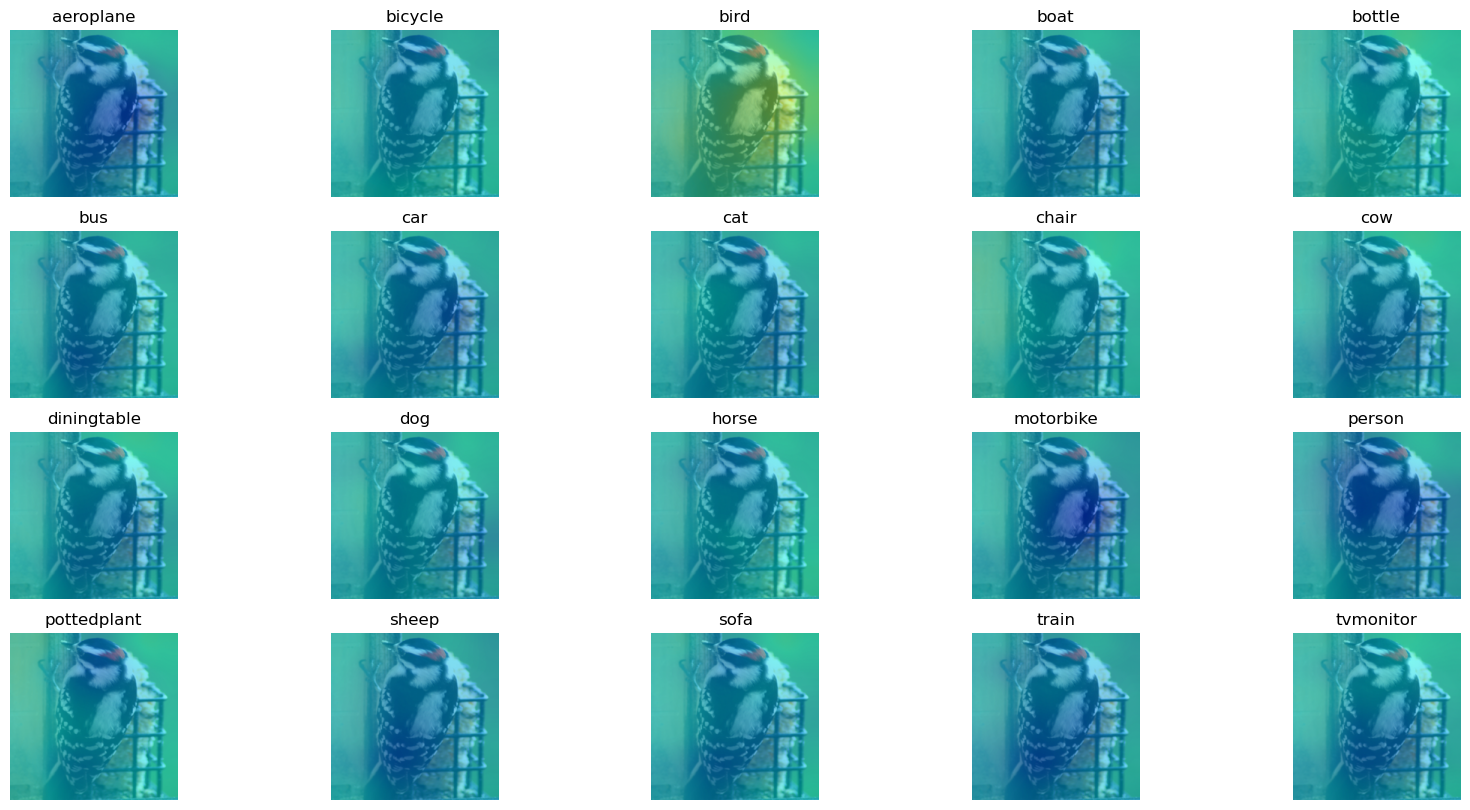

In [14]:
def heatmap_on_image(img, heatmap, alpha=0.5):
  """
  draw heatmap on image
  Input
  - img: torch.tensor (C, H, W)
  - heatmap: torch.tensor (7, 7)
  - alpha: float
  Output
  - ret: np.array
  """
  # img to np.array
  img = (unnormalize(img.numpy())* 255.0).astype(np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

  heatmap = heatmap.numpy().astype(np.uint8)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  ret = cv2.addWeighted(heatmap, alpha, img, 1-alpha, 0)
  ret = cv2.cvtColor(ret, cv2.COLOR_BGR2RGB)

  # img to pytorch tensor
  ret = TF.to_tensor(ret)
  return ret

interp_cams = torch.nn.functional.interpolate(traincam, size=trainimg.shape[2:], mode='bicubic')

# plot trainimg with traincam
fig = plt.figure(figsize=(20, 10))
for idx_class in range(num_classes):
    ax = fig.add_subplot(4,5,idx_class+1)
    img = heatmap_on_image(trainimg[idx], interp_cams[idx, idx_class, :, :])
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(label_str[idx_class])
    ax.axis('off')

In [16]:
def label_list_to_str(labels, label_to_str, threshold=0.5):
    """
    Boolean label list to string list.
    """
    ret = []
    labels = (labels > threshold)
    for i, label in enumerate(labels):
        if label == 1:
          ret.append(label_to_str[i])
    ret = ', '.join(ret)
    return ret 


In [20]:
print(traintarget[idx], trainpred[idx], trainmask[idx])

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float16) tensor([0.0311, 0.0822, 0.8242, 0.0523, 0.1428, 0.0649, 0.0480, 0.0644, 0.1120,
        0.0593, 0.0705, 0.0722, 0.0846, 0.0337, 0.0262, 0.0983, 0.0407, 0.0635,
        0.0334, 0.0617]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
